# MNIST digit recognition with a 3-layer Perceptron

This example is inspired form [this notebook](https://github.com/jeremiecoullon/SGMCMCJax/blob/master/docs/nbs/BNN.ipynb) in the SGMCMCJax repository. We try to use a 3-layer neural network to recognise the digits in the MNIST dataset.

In [1]:
import jax
import jax.nn as nn
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np

## Data preparation

We download the MNIST data using `tensorflow-datasets`:

In [2]:
import tensorflow_datasets as tfds

mnist_data, _ = tfds.load(
    name="mnist", batch_size=-1, with_info=True, as_supervised=True
)
mnist_data = tfds.as_numpy(mnist_data)
data_train, data_test = mnist_data["train"], mnist_data["test"]

Now we need to apply several transformations to the dataset before splitting it into a test and a test set:
- The images come into 28x28 pixels matrices; we reshape them into a vector;
- The images are arrays of RGB codes between 0 and 255. We normalize them by the maximum value to get a range between 0 and 1;
- We hot-encode category numbers.

In [3]:
def one_hot_encode(x, k, dtype=np.float32):
    "Create a one-hot encoding of x of size k."
    return np.array(x[:, None] == np.arange(k), dtype)


def prepare_data(dataset: tuple, num_categories=10):
    X, y = dataset
    y = one_hot_encode(y, num_categories)

    num_examples = X.shape[0]
    num_pixels = 28 * 28
    X = X.reshape(num_examples, num_pixels)
    X = X / 255.0

    return jnp.array(X), jnp.array(y), num_examples


def batch_data(rng_key, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    while True:
        _, rng_key = jax.random.split(rng_key)
        idx = jax.random.choice(
            key=rng_key, a=jnp.arange(data_size), shape=(batch_size,)
        )
        minibatch = tuple(elem[idx] for elem in data)
        yield minibatch


X_train, y_train, N_train = prepare_data(data_train)
X_test, y_test, N_test = prepare_data(data_train)

## Model:  3-layer perceptron

We will use a very simple (bayesian) neural network in this example: A MLP with gaussian priors on the weights. We first need a function that computes the model's logposterior density given the data and the current values of the parameters. If we note $X$ the array that represents an image and $y$ the array such that $y_i = 0$  if the image is in category $i$, $y_i=1$ otherwise, the model can be written as:

\begin{align*}
  \boldsymbol{p} &= \operatorname{NN}(X)\\
  \boldsymbol{y} &\sim \operatorname{Categorical}(\boldsymbol{p})
\end{align*}

In [4]:
def predict_fn(parameters, X):
    """Returns the probability for the image represented by X
    to be in each category given the MLP's weights vakues.

    """
    activations = X
    for W, b in parameters[:-1]:
        outputs = jnp.dot(W, activations) + b
        activations = nn.softmax(outputs)

    final_W, final_b = parameters[-1]
    logits = jnp.dot(final_W, activations) + final_b
    return nn.log_softmax(logits)


def logprior_fn(parameters):
    """Compute the value of the log-prior density function."""
    logprob = 0.0
    for W, b in parameters:
        logprob += jnp.sum(stats.norm.logpdf(W))
        logprob += jnp.sum(stats.norm.logpdf(b))
    return logprob


def loglikelihood_fn(parameters, data):
    """Categorical log-likelihood"""
    X, y = data
    return jnp.sum(y * predict_fn(parameters, X))


def compute_accuracy(parameters, X, y):
    """Compute the accuracy of the model.

    To make predictions we take the number that corresponds to the highest probability value.
    """
    target_class = jnp.argmax(y, axis=1)
    predicted_class = jnp.argmax(
        jax.vmap(predict_fn, in_axes=(None, 0))(parameters, X), axis=1
    )
    return jnp.mean(predicted_class == target_class)

## Sample from the posterior distribution of the perceptron's weights

Now we need to get initial values for the parameters, and we simply sample from their prior distribution:

In [5]:
def init_parameters(rng_key, sizes):
    """

    Parameter
    ----------
    rng_key
        PRNGKey used by JAX to generate pseudo-random numbers
    sizes
        List of size for the subsequent layers. The first size must correspond
        to the size of the input data and the last one to the number of
        categories.

    """
    num_layers = len(sizes)
    keys = jax.random.split(rng_key, num_layers)
    return [
        init_layer(rng_key, m, n) for rng_key, m, n in zip(keys, sizes[:-1], sizes[1:])
    ]


def init_layer(rng_key, m, n, scale=1e-2):
    """Initialize the weights for a single layer."""
    key_W, key_b = jax.random.split(rng_key)
    return (scale * jax.random.normal(key_W, (n, m))), scale * jax.random.normal(
        key_b, (n,)
    )

We now sample from the model's posteriors. We discard the first 1000 samples until the sampler has reached the typical set, and then take 2000 samples. We record the model's accuracy with the current values every 100 steps.

In [6]:
%%time

import blackjax
from blackjax.sgmcmc.gradients import grad_estimator

data_size = len(y_train)
batch_size = int(0.01 * data_size)
layer_sizes = [784, 100, 10]
step_size = 5e-5
num_warmup = 1000
num_samples = 2000

# Batch the data
rng_key = jax.random.PRNGKey(1)
batches = batch_data(rng_key, (X_train, y_train), batch_size, data_size)

# Build the SGLD kernel
schedule_fn = lambda _: step_size  # constant step size
grad_fn = grad_estimator(logprior_fn, loglikelihood_fn, data_size)
sgld = blackjax.sgld(grad_fn, schedule_fn)

# Set the initial state
init_positions = init_parameters(rng_key, layer_sizes)
state = sgld.init(init_positions, next(batches))

# Sample from the posterior
accuracies = []
samples = []
steps = []
for step in range(num_samples + num_warmup):
    _, rng_key = jax.random.split(rng_key)
    batch = next(batches)
    state = sgld.step(rng_key, state, batch)
    if step % 100 == 0:
        accuracy = compute_accuracy(state.position, X_test, y_test)
        accuracies.append(accuracy)
        steps.append(step)
    if step > num_warmup:
        samples.append(state.position)

CPU times: user 2min 5s, sys: 7.18 s, total: 2min 13s
Wall time: 1min 2s


Let us plot the accuracy at different points in the sampling process:

[]

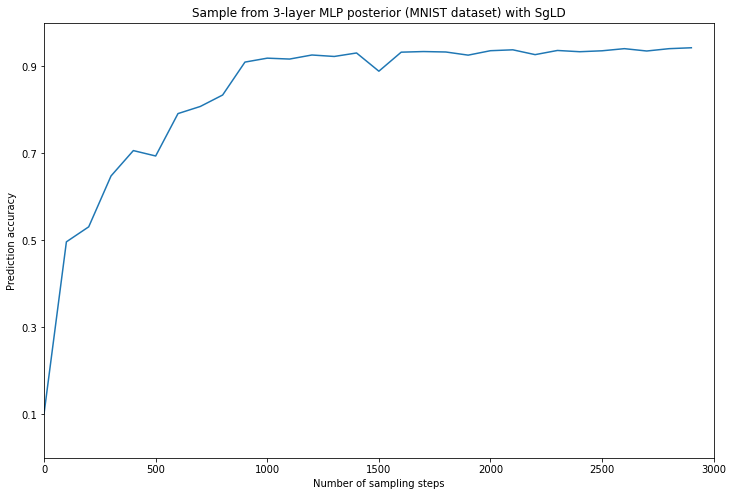

In [7]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(steps, accuracies)
ax.set_xlabel("Number of sampling steps")
ax.set_ylabel("Prediction accuracy")
ax.set_xlim([0, num_warmup + num_samples])
ax.set_ylim([0, 1])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.title("Sample from 3-layer MLP posterior (MNIST dataset) with SgLD")
plt.plot()

In [8]:
print(f"The average accuracy in the sampling phase is {np.mean(accuracies[10:]):.2f}")

The average accuracy in the sampling phase is 0.93


Which is not a bad accuracy at all for such a simple model and after only 1000 steps! Remember though that we draw samples from the posterior distribution of the digit probabilities; we can thus use this information to filter out examples for which the model is "unsure" of its prediction.

Here we will say that the model is unsure of its prediction for a given image if the digit that is most often predicted for this image is predicted less tham 95% of the time.

In [9]:
predicted_class = np.exp(
    np.stack([jax.vmap(predict_fn, in_axes=(None, 0))(s, X_test) for s in samples])
)

In [10]:
max_predicted = [np.argmax(predicted_class[:, i, :], axis=1) for i in range(60000)]
freq_max_predicted = np.array(
    [
        (max_predicted[i] == np.argmax(np.bincount(max_predicted[i]))).sum() / 2000
        for i in range(60000)
    ]
)
certain_mask = freq_max_predicted > 0.95

Let's plot a few examples where the model was very uncertain:

[0.     0.1765 0.129  0.     0.194  0.015  0.212  0.     0.153  0.12  ]


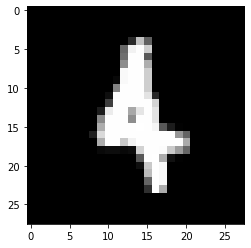

[0.     0.1355 0.053  0.2045 0.     0.201  0.0095 0.     0.254  0.142 ]


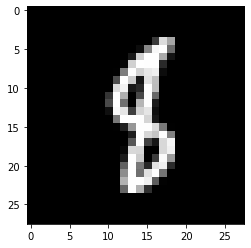

[0.239  0.     0.072  0.006  0.     0.23   0.     0.     0.188  0.2645]


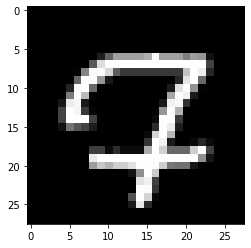

[0.2475 0.     0.022  0.0705 0.     0.235  0.     0.0015 0.2645 0.1585]


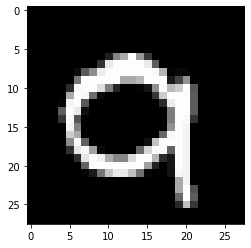

[0.04   0.     0.151  0.1755 0.     0.0505 0.1725 0.269  0.0015 0.1395]


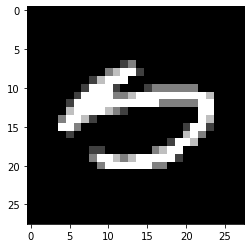

[0.     0.     0.078  0.2245 0.     0.236  0.2765 0.     0.1795 0.005 ]


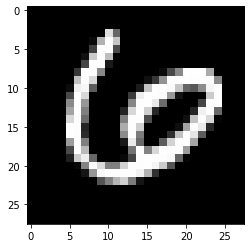

[0.0565 0.     0.008  0.0905 0.156  0.1565 0.     0.278  0.037  0.217 ]


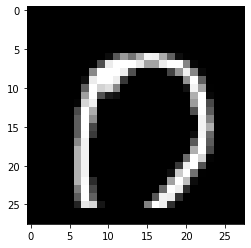

[0.2785 0.     0.2955 0.0725 0.     0.     0.151  0.     0.     0.202 ]


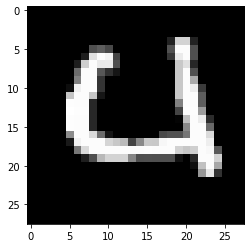

[0.168  0.     0.007  0.2935 0.     0.     0.     0.1005 0.2975 0.133 ]


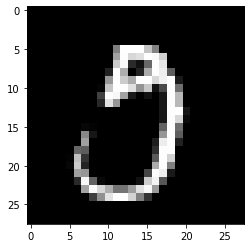

[0.     0.     0.1835 0.0175 0.034  0.018  0.0015 0.3025 0.15   0.2925]


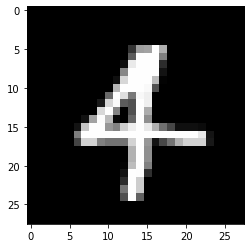

In [11]:
most_uncertain_idx = np.argsort(freq_max_predicted)

for i in range(10):
    print(np.bincount(max_predicted[most_uncertain_idx[i]]) / 2000)
    fig = plt.figure()
    plt.imshow(X_test[most_uncertain_idx[i]].reshape(28, 28), cmap="gray")
    plt.show()

And now compute the average accuracy over all the samples without these uncertain predictions:

In [12]:
avg_accuracy = np.mean(
    [compute_accuracy(s, X_test[certain_mask], y_test[certain_mask]) for s in samples]
)

In [13]:
print(
    f"The average accuracy removing the samples for which the model is uncertain is {avg_accuracy:.3f}"
)

The average accuracy removing the samples for which the model is uncertain is 0.983
